<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/normalizied_avarege_performans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

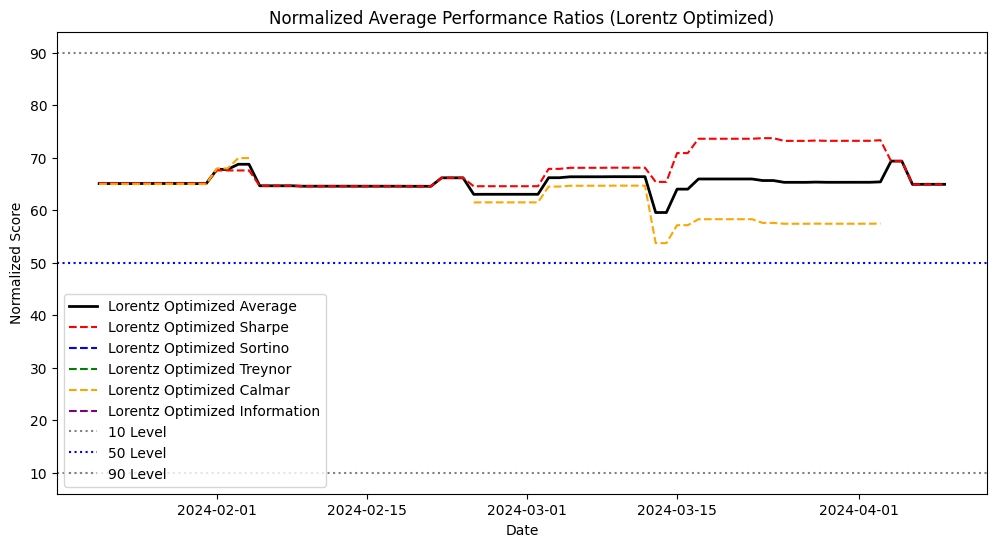

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# CoinGecko API'den veri çekme
COINGECKO_URL = "https://api.coingecko.com/api/v3/coins/markets"
HEADERS = { 'User-Agent': 'Mozilla/5.0' }
PARAMS = {
    'vs_currency': 'usd',
    'order': 'market_cap_desc',
    'per_page': 100,
    'page': 1,
    'sparkline': False
}

response = requests.get(COINGECKO_URL, headers=HEADERS, params=PARAMS)
data = response.json()

# Coin fiyatlarını ve tarihleri alma
dates = pd.date_range(start="2024-01-01", periods=len(data), freq='D')
prices = np.array([coin['current_price'] for coin in data])
df = pd.DataFrame({'Date': dates, 'Close': prices})
df.set_index('Date', inplace=True)

# Risk-Free Rate
risk_free_rate = 0.001 / 60

# Getiri Hesaplamaları
df['PriceChange'] = df['Close'].diff()
df['PortfolioReturn'] = df['PriceChange'] / df['Close'].shift(1)

df['CommodityReturn'] = df['PortfolioReturn']  # Örnek için benzer kabul edildi

# Performans Oranları Hesaplamaları
df['PortfolioStdDev'] = df['PortfolioReturn'].rolling(20).std()
df['AveragePortfolioReturn'] = df['PortfolioReturn'].rolling(20).mean()
df['SharpeRatio'] = (df['AveragePortfolioReturn'] - risk_free_rate) / df['PortfolioStdDev']

df['NegativeReturns'] = df['PortfolioReturn'].apply(lambda x: x if x < 0 else np.nan)
df['DownsideDeviation'] = df['NegativeReturns'].rolling(20).std()
df['SortinoRatio'] = (df['AveragePortfolioReturn'] - risk_free_rate) / df['DownsideDeviation']

# Beta Hesaplaması
df['MeanCommodityReturn'] = df['CommodityReturn'].rolling(20).mean()
df['Covariance'] = df[['PortfolioReturn', 'CommodityReturn']].rolling(20).cov().unstack()[('PortfolioReturn', 'CommodityReturn')]
df['CommodityVariance'] = df['CommodityReturn'].rolling(20).var()
df['Beta'] = df['Covariance'] / df['CommodityVariance']
df['TreynorRatio'] = (df['AveragePortfolioReturn'] - risk_free_rate) / df['Beta']

# Calmar Ratio
df['MaxDrawdown'] = df['Close'].rolling(20).max() - df['Close'].rolling(20).min()
df['CalmarRatio'] = df['AveragePortfolioReturn'] / df['MaxDrawdown']

# Tracking Error ve Information Ratio
df['TrackingError'] = (df['PortfolioReturn'] - df['CommodityReturn']).rolling(20).std()
df['InformationRatio'] = (df['AveragePortfolioReturn'] - df['MeanCommodityReturn']) / df['TrackingError']

# Lorentz Normalizasyon Fonksiyonu
def lorentz_normalize(ratio):
    if pd.isna(ratio) or ratio < -1 or ratio > 1:
        return np.nan
    transformed = np.sign(ratio) * np.log(1 + abs(ratio))
    return ((transformed + np.log(2)) / (2 * np.log(2))) * 100

# Lorentz Normalizasyonunu Uygula
df['NormalizedSharpe'] = df['SharpeRatio'].apply(lorentz_normalize)
df['NormalizedSortino'] = df['SortinoRatio'].apply(lorentz_normalize)
df['NormalizedTreynor'] = df['TreynorRatio'].apply(lorentz_normalize)
df['NormalizedCalmar'] = df['CalmarRatio'].apply(lorentz_normalize)
df['NormalizedInformation'] = df['InformationRatio'].apply(lorentz_normalize)

df['AverageNormalized'] = df[['NormalizedSharpe', 'NormalizedSortino', 'NormalizedTreynor', 'NormalizedCalmar', 'NormalizedInformation']].mean(axis=1)

# Grafik Çizme
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['AverageNormalized'], label='Lorentz Optimized Average', color='black', linewidth=2)
plt.plot(df.index, df['NormalizedSharpe'], label='Lorentz Optimized Sharpe', color='red', linestyle='dashed')
plt.plot(df.index, df['NormalizedSortino'], label='Lorentz Optimized Sortino', color='blue', linestyle='dashed')
plt.plot(df.index, df['NormalizedTreynor'], label='Lorentz Optimized Treynor', color='green', linestyle='dashed')
plt.plot(df.index, df['NormalizedCalmar'], label='Lorentz Optimized Calmar', color='orange', linestyle='dashed')
plt.plot(df.index, df['NormalizedInformation'], label='Lorentz Optimized Information', color='purple', linestyle='dashed')

plt.axhline(10, color='gray', linestyle='dotted', label='10 Level')
plt.axhline(50, color='blue', linestyle='dotted', label='50 Level')
plt.axhline(90, color='gray', linestyle='dotted', label='90 Level')

plt.legend()
plt.title("Normalized Average Performance Ratios (Lorentz Optimized)")
plt.xlabel("Date")
plt.ylabel("Normalized Score")
plt.show()
